In [2]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import MONGO_URL, END_DATE
from scripts.analysis import data, plot

plot.init_matplotlib()
W, H = 6, 2.5

In [ ]:
repo_name = "gqylpy/funccache"
stars = data.get_fake_stars_by_month()
this_repo = stars[stars.repo == repo_name][["month", "n_stars", "n_stars_fake"]]
this_repo.n_stars = this_repo.n_stars.cumsum()
this_repo.n_stars_fake = this_repo.n_stars_fake.cumsum()
this_repo

In [4]:
repo2 = stars[stars.repo == "microsoft/vscode"][["month", "n_stars", "n_stars_fake"]]
repo2 = repo2[repo2.month != "2024-10"]
repo2

,month,n_stars,n_stars_fake
166533,2019-07,1914.0,12.0
166534,2019-08,1886.0,8.0
166535,2019-09,1856.0,16.0
166536,2019-10,1770.0,13.0
166537,2019-11,2707.0,21.0
...,...,...,...
166592,2024-06,1190.0,56.0
166593,2024-07,1375.0,59.0
166594,2024-08,1269.0,57.0
166595,2024-09,1369.0,106.0


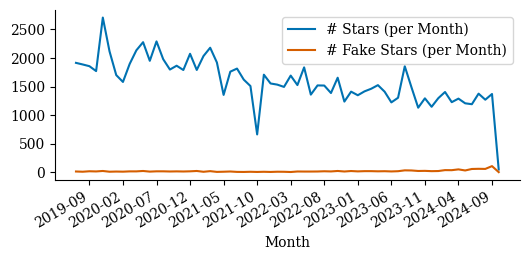

In [14]:
fig, ax = plt.subplots(figsize=(W, H))
repo2[["month", "n_stars"]].plot(
    x="month",
    color="C0",
    ax=ax,
)
repo2[["month", "n_stars_fake"]].plot(
    x="month",
    color="C2",
    ax=ax,
)
ax.set_xlabel("Month")
ax.set_xticks(range(2, len(repo2), 5))
ax.set_xticklabels(repo2["month"].iloc[2::5])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["# Stars (per Month)", "# Fake Stars (per Month)"])
fig.autofmt_xdate()
fig.savefig("plots/vscode-timeline.pdf", bbox_inches="tight")

In [3]:
sample_repos = data.get_sample_stars_by_month()
sample_repos.insert(
    2,
    "timestep",
    sample_repos.groupby("repo").month.transform(lambda x: pd.factorize(x)[0]),
)
sample_repos.head()

,repo,month,timestep,n_stars
0,03taco/crypto-aml-check,2024-08,0,253
1,04x/ICG-AutoExploiterBoT,2019-07,0,2
2,04x/ICG-AutoExploiterBoT,2019-08,1,9
3,04x/ICG-AutoExploiterBoT,2019-09,2,11
4,04x/ICG-AutoExploiterBoT,2019-10,3,9


In [4]:
repo_to_stars = (
    sample_repos.groupby("repo")
    .agg({"n_stars": "sum"})
    .sort_values("n_stars", ascending=False)
    .reset_index()
)
compare_repos = set(
    repo_to_stars[(90 <= repo_to_stars.n_stars) & (repo_to_stars.n_stars <= 120)].repo
)
len(compare_repos)

1363

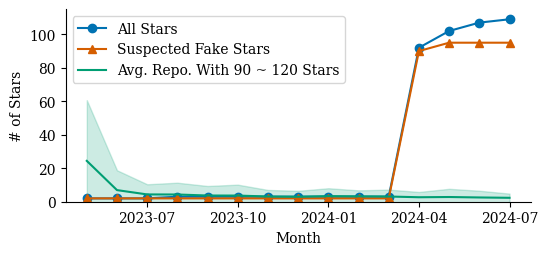

In [5]:
fig, ax = plt.subplots(figsize=(W, H))
this_repo[["month", "n_stars"]].plot(
    x="month",
    color="C0",
    ax=ax,
    marker="o",
)
this_repo[["month", "n_stars_fake"]].plot(
    x="month",
    color="C2",
    ax=ax,
    marker="^",
)
sns.lineplot(
    x="timestep",
    y="n_stars",
    data=sample_repos[sample_repos.repo.isin(compare_repos) & (sample_repos.timestep < len(this_repo))],
    color="C1",
    ax=ax,
    #marker="s",
    errorbar="sd"
)
# ax.set_title(f"Star History of {repo_name} ({int(this_repo["n_stars"].iloc[-1])} Stars)")
ax.set_ylabel("# of Stars")
ax.set_xlabel("Month")
ax.set_xticks(range(2, len(this_repo), 3))
ax.set_xticklabels(this_repo["month"].iloc[2::3])
ax.set_ylim(0, 115)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["All Stars", "Suspected Fake Stars", "Avg. Repo. With 90 ~ 120 Stars"])
fig.savefig("plots/example-timeline.pdf", bbox_inches="tight")

In [6]:
sample_actors = pd.read_csv(f"data/{END_DATE}/sample_actor_events.csv")
fake_actors = pd.read_csv(f"data/{END_DATE}/fake_actor_events.csv")

with pymongo.MongoClient(MONGO_URL) as client:
    fake_actor_ids = client.fake_stars.clustered_stars.find(
        {"repo": repo_name, "clustered": True}
    ).distinct("actor")

fake_actors = fake_actors[fake_actors.actor.isin(fake_actor_ids)].melt(
    id_vars=["actor"],
    value_vars=[x for x in fake_actors.columns if x.endswith("Event")],
    var_name="event",
    value_name="count",
)
sample_actors = sample_actors.melt(
    id_vars=["actor"],
    value_vars=[x for x in sample_actors.columns if x.endswith("Event")],
    var_name="event",
    value_name="count",
)

fake_actors["percentage"] = fake_actors["count"] / fake_actors.groupby("actor")[
    "count"
].transform("sum")
sample_actors["percentage"] = sample_actors["count"] / sample_actors.groupby("actor")[
    "count"
].transform("sum")

fake_actors["group"], sample_actors["group"] = "Suspected Fakes", "Random Stargazer"

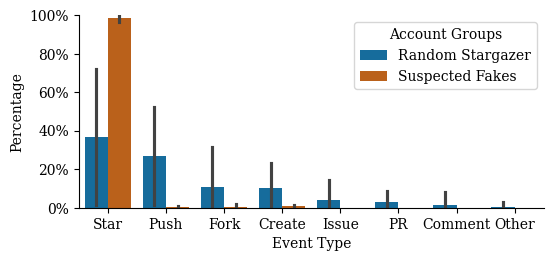

In [7]:
data = pd.concat([sample_actors, fake_actors])
data["event"] = data["event"].map(plot.shorten_gharchive_event)
fig, ax = plt.subplots(figsize=(W, H))
sns.barplot(
    x="event",
    y="percentage",
    data=data,
    hue="group",
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    errorbar="sd",
    ax=ax,
)
ax.set_ylabel("Percentage")
ax.set_xlabel("Event Type")
ax.legend(title="Account Groups")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#fig.autofmt_xdate()
fig.savefig("plots/example-events.pdf", bbox_inches="tight", dpi=300)